# Preliminary experiment to examine the effect of the numbers of forward passes to the consistency of the uncertainty estimate 

### Import the libraries 

In [1]:
import os
import csv
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all uncertainty-files in a folder (pickle-format)

In [2]:
def list_pkl_files(resultsdir):
    pkl_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.pkl'):
                    if all('' == s for s in subdir):
                        pkl_files.append(name)
                    else:
                        pkl_files.append(os.path.join(subdirname, name))
    
        pkl_files.sort()

    return pkl_files

### Initialize some paths and parameters

In [3]:
resultsdir = "results/exp2/prob_0.50"
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
pkl_files = list_pkl_files(resultsdir)

forward_passes = [2, 4]
try:
    prob = float(os.path.splitext(pkl_files[0].split("prob")[-1])[0])
except:
    pass

metric = 'std' # choose between 'std' (standard-deviation) and 'var' (variance)

### Initialize the pandas-dataframe and csv-writer 

In [4]:
df = pd.DataFrame(columns=["number of forward passes", metric])

with open(os.path.join(resultsdir, 'forward_passes_{:s}_prob{:.2f}.csv'.format(metric, prob)), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['number of forward passes', 'total number of observations', 'mean', metric])

###  Load the uncertainty-metrics and store the data in a pandas-dataframe 

In [5]:
for p in range(len(pkl_files)):
    pkl_file = pkl_files[p]
    fp = int(pkl_file.split("_")[2])
    
    with open(os.path.join(resultsdir, pkl_file), 'rb') as handle:
        uncertainties = pickle.load(handle)
        all_vals = []
        for key, val in uncertainties.items():
            transposed = list(zip(*val))
            if metric == 'var':
                vals = [np.nanvar(values) for values in transposed]
            elif metric == 'std':
                vals = [np.nanstd(values) for values in transposed]
            all_vals.append(vals)

        all_vals = list(chain.from_iterable(all_vals))
        current_iter = [fp for k in range(len(all_vals))]
        data_tuples = list(zip(current_iter, all_vals))

        cur_df = pd.DataFrame(data=data_tuples, columns=["number of forward passes", metric])
        df = pd.concat([df, cur_df])

### Store the processed data in the csv-file

In [6]:
if not df.empty:
    num_obs = df.groupby(["number of forward passes"]).size()
    means = df.groupby(["number of forward passes"]).mean()
    if metric == 'var':
        variations = df.groupby(["number of forward passes"]).var()
    elif metric == 'std':
        variations = df.groupby(["number of forward passes"]).std()

    with open(os.path.join(resultsdir, 'forward_passes_{:s}_prob{:.2f}.csv'.format(metric, prob)), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        num_obs = num_obs.to_list()
        means = means.values 
        variations = variations.values
        for it in range(len(forward_passes)):
            iter = int(forward_passes[it])
            no = int(num_obs[it])
            me = float(means[it])
            va = float(variations[it])
            csvwriter.writerow([iter, no, me, va]) 

### Plot the processed data 

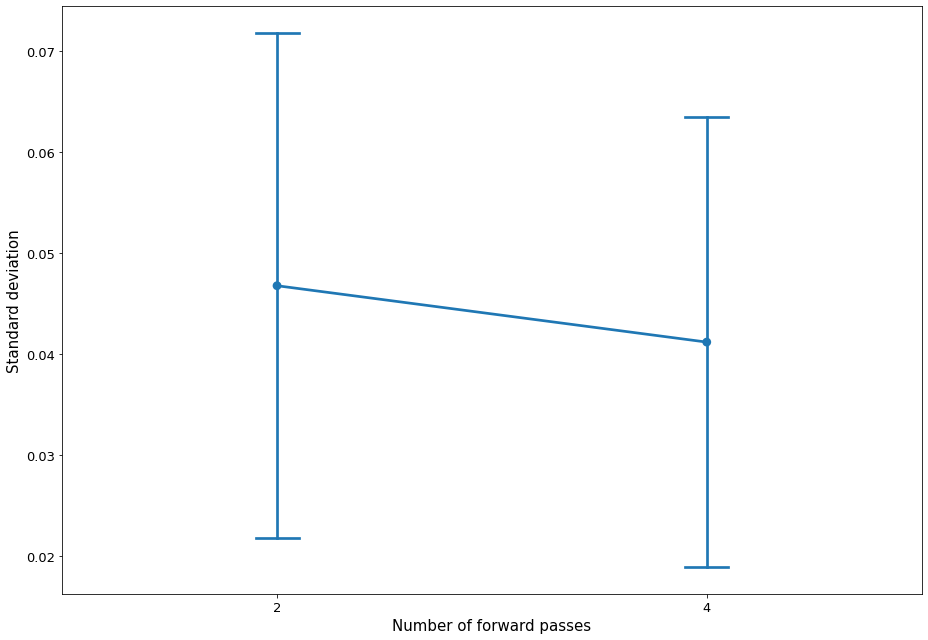

In [7]:
font_size = 15
digit_size = 13
annot_size = 14

if not df.empty:
    f, ax = plt.subplots(figsize=(13, 9))
    ax = sns.pointplot(x="number of forward passes", y=metric, data=df, ci="sd", capsize=.1)
    # ax = sns.lineplot(x="number of forward passes", y=metric, ci=95, data=df, palette = "tab10")
    ax.tick_params(labelrotation=0, labelsize=digit_size)

    plt.xlabel("Number of forward passes", fontsize=font_size)
    if metric == 'var':
        plt.ylabel("Variance", fontsize=font_size)
    elif metric == 'std':
        plt.ylabel("Standard deviation", fontsize=font_size)

    plt.tight_layout()
    plt.savefig(os.path.join(resultsdir, 'forward_passes_{:s}_prob{:.2f}.jpg'.format(metric, prob)))  